In [1]:
import numpy as np
import pandas as pd
import scipy
import ast
from sklearn.preprocessing import MinMaxScaler
import torch
from main import *
import scipy.optimize as opt

In [ ]:
#%% Estimated treatment-response curves 

# Real-world - train
df = pd.read_csv('data/food_df_rob.csv')
aid_sds = df.groupby('country')['ad_sdg2_aid'].apply(np.std).values

year = 2018
df = df[df['year'] == year]
msfi_rate_prev = df['prev_msfi'].values
pop_previous = df['pop'].values


# Prepare real world data
X = df[['ad_exc2_aid_gdp', 'infl', 'food_prod', 'food_imp_net_gdp',
        'log_gdp', 'log_gdp_pc', 'gdp_pc_grw', 'gov_score', 'e_pt_coup', 'disast_affect', 'fight', 'prec_z', 'net_dens']].to_numpy()
A = df['ad_sdg2_aid']
A = A.to_numpy()
Y = df['change_msfi'].to_numpy()

n = X.shape[0]
p = X.shape[1]

data = np.concatenate([Y.reshape(n,1), A.reshape(n,1), X],axis=1)

# Data standardization: min-max scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[:,2:])
data_train = np.concatenate([data[:,0:2], data_scaled], axis=1)

# Real world - test
df = pd.read_csv('data/food_df_rob.csv')
year = 2019
df = df[df['year'] == year]
msfi_rate_curr = df['prev_msfi'].values
pop_curr = df['pop'].values

# Prepare real world data
X = df[['ad_exc2_aid_gdp', 'infl', 'food_prod', 'food_imp_net_gdp',
        'log_gdp', 'log_gdp_pc', 'gdp_pc_grw', 'gov_score', 'e_pt_coup', 'disast_affect', 'fight', 'prec_z', 'net_dens']].to_numpy()
A = df['ad_sdg2_aid']
A = A.to_numpy()
Y = df['change_msfi'].to_numpy()

n = X.shape[0]
p = X.shape[1]

data2 = np.concatenate([Y.reshape(n,1), A.reshape(n,1), X],axis=1)

# Data standardization: min-max scaler
scaler = MinMaxScaler()
data_scaled2 = scaler.fit_transform(data2[:,2:])
data_test = np.concatenate([data2[:,0:2], data_scaled2], axis=1)

# Hyperpar list
hyper_opt_list = open("hyperpars/hyperpars_opt_real.txt", "r")
hyper_opt_list = hyper_opt_list.read()
hyper_opt = ast.literal_eval(hyper_opt_list)
opt_hyperpars = hyper_opt[-1]

# Set all seeds
np.random.seed(123)
torch.manual_seed(123)

# Estimate model
data_train_bae, mod_BAE = BAE(data_train, opt_hyperpars)    
device = torch.device('cpu')  
X = torch.from_numpy(data_test[:,2:].astype(np.float32))
X = X.to(device)
X_reduced, _, _ = mod_BAE(X)
X_reduced = X_reduced.cpu().detach().numpy()
data_test_bae = np.concatenate([data_test[:,0:2],X_reduced], axis=1)                                     
aid_max = np.max(data_train[:,1])
aid_min = np.min(data_train[:,1])
aid_random = np.random.uniform(aid_min, aid_max, (data_train_bae.shape[0], opt_hyperpars['m_scw']))
data_train_scw = SCw(data_train_bae, aid_random, opt_hyperpars)
cf_model, _, _ = CAUSFOR(data_train_scw, opt_hyperpars)

In [ ]:

# Optimal allocation

def optimal_allocation(data_test, msfi_rate, population, cf_model):
    
    n = data_test.shape[0]
    A_obs = data_test[:,1]
    budget = np.sum(A_obs)
    covariate_data = data_test[:,2:]
    
    Y_0 = (data_test[:,0]/100 - cate_vals * A_obs) * population
    
    Y_curr = np.sum((data_test[:,0]/100) * population)

    def objective(A_opt):
        Y_opt = np.maximum((Y_0 + cate_vals * A_opt), 0) * population
        return np.sum(Y_opt)
    
    # Constraint: Total aid remains the same
    constraint = {'type': 'eq', 'fun': lambda A_opt: np.sum(A_opt) - A_obs}
    
    # Bounds: Aid cannot be negative
    aid_std = np.std(A_obs)  # Standard deviation of observed aid
    bounds = [(A_obs[i] - aid_std, A_obs[i] + aid_std) for i in range(n)]

    # Initial guess: Distribute aid proportional to need
    initial_guess = data_test[:,0]/100

    # Solve the optimization problem
    result = opt.minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=[constraint])
    
    A_opt = result.x
    Y_opt = objective(A_opt)
    return A_opt, Y_opt, Y_curr
    # if result.success:
    #     A_opt = result.x  # Optimized aid allocation

    #     # **Manually adjust to enforce budget**
    #     A_opt *= budget / np.sum(A_opt)

    #     Y_opt = objective(A_opt)  # Minimized total food-insecure population
        
    #     # Debugging: Check outputs
    #     print("Optimized Budget:", np.sum(A_opt))
    #     print("Original Budget:", budget)
    #     print("Final Constraint Violation:", np.sum(A_opt) - budget)
    #     print("Optimizer Message:", result.message)

    #     return A_opt, Y_opt, Y_curr
    # else:
    #     raise ValueError("Optimization failed to converge!")

# Example Usage:
# Assuming causal forests have been trained and stored in `causal_forest_models`
A_opt, Y_opt, Y_curr = optimal_allocation(data_test, data_test[:,0], population, cate_vals)

print("Optimized Aid Allocation:", A_opt)
print("Current Total Food-Insecure Population:", Y_curr)
print("Minimized Total Food-Insecure Population:", Y_opt)

Optimized Aid Allocation: [1.6392951515e+08 3.7100000000e-01 3.5800000000e-01 9.6000000000e-02
 6.5800000000e-01 1.7688848882e+08 9.2000000000e-02 1.4200000000e-01
 5.3100000000e-01 3.8200000000e-01 5.7000000000e-01 2.6500000000e-01
 1.4500000000e-01 5.2600000000e-01 1.7600000000e-01 2.9300000000e-01
 8.4369997654e+07 7.4214398807e+08 3.8300000000e-01 3.9500000000e-01
 4.5200000000e-01 4.0900000000e-01 7.0000000000e-02 4.0600000000e-01
 4.5800000000e-01 1.4694607869e+08 4.4100000000e-01 3.5700000000e-01
 7.6000000000e-02 2.7500000000e-01 1.3400000000e-01 2.3800000000e-01
 1.4400000000e-01 1.2900000000e-01 3.5900000000e-01 2.0700000000e-01
 7.8800000000e-01 1.5100000000e-01 5.6400000000e-01 5.4230539262e+08
 3.3800000000e-01 7.1288402521e+07 4.4900000000e-01 2.1300000000e-01
 3.5100000000e-01 8.3000000000e-01 4.2200000000e-01 1.2500000000e-01
 1.3119991487e+07 5.9600000000e-01 2.8800000000e-01 2.2100000000e-01
 4.6875731487e+07 1.3799801799e+08 1.8300000000e-01 8.9684213232e+08
 6.67000

In [ ]:
print(Y_curr - Y_opt)
print(Y_curr/Y_opt)


-2563510765819458.5
2.9528396604167934e-07


In [ ]:
print(np.sum(A_opt))

A_obs = data_test[:,1]
budget = np.sum(A_obs)
print(budget)

3022707752.531168
8494519607.030955


In [ ]:
optimal_allocation(data_test, "x", "y", population, cate_vals)

arr = np.array([1.84635838e+01, 1.16106403e+00, 7.92593723e-01, 3.79359496e-01,
                3.73296590e+00, 1.26176891e+01, 5.42378516e-01, 4.18010760e+00,
                3.42427976e-01, 3.13007140e+00, 5.74696685e+00, 5.23659892e+00,
                1.68253058e-01, 1.44298120e+00, 1.06643192e+00, 1.14710741e+00,
                9.83326665e+00, 3.87743635e+01, 1.93181405e+00, 6.93335768e+00,
                2.88951676e+00, 2.61964792e+00, 6.51047877e+00, 3.01461206e-01,
                3.94214849e-01, 1.59584681e+01, 4.73959744e+00, 3.60032137e-01,
                4.70952817e+00, 1.64731882e+00, 3.58917109e-02, 4.99371970e-01,
                3.69242870e-01, 3.83509048e-01, 3.63686691e+00, 6.83504807e-02,
                8.32513333e+00, 1.67539828e-01, 4.13513607e-01, 2.61906478e+01,
                3.19943397e+00, 9.63258276e+00, 8.63298747e+00, 1.58149932e+00,
                5.72384638e+00, 1.19486991e+00, 7.82137719e-01, 1.42025371e+00,
                1.03672924e+01, 7.10847254e-01, 8.43966686e-01, 6.35502935e+00,
                1.16038583e+01, 1.33992908e+01, 7.67917182e+00, 3.54670822e+01,
                2.34074555e+00])

# Print with full precision and no scientific notation
np.set_printoptions(suppress=True, precision=10)
print(arr)



[18.4635838     1.16106403    0.792593723   0.379359496   3.7329659
 12.6176891     0.542378516   4.1801076     0.342427976   3.1300714
  5.74696685    5.23659892    0.168253058   1.4429812     1.06643192
  1.14710741    9.83326665   38.7743635     1.93181405    6.93335768
  2.88951676    2.61964792    6.51047877    0.301461206   0.394214849
 15.9584681     4.73959744    0.360032137   4.70952817    1.64731882
  0.0358917109  0.49937197    0.36924287    0.383509048   3.63686691
  0.0683504807  8.32513333    0.167539828   0.413513607  26.1906478
  3.19943397    9.63258276    8.63298747    1.58149932    5.72384638
  1.19486991    0.782137719   1.42025371   10.3672924     0.710847254
  0.843966686   6.35502935   11.6038583    13.3992908     7.67917182
 35.4670822     2.34074555  ]


In [ ]:
optim_all_df = pd.DataFrame({
    'A_opt': A_opt,
})

optim_all_df["country"] = df["country"].values
optim_all_df

,A_opt,country
0,2.297433e+08,Afghanistan
1,1.479770e+08,Albania
2,1.427918e+08,Argentina
3,3.829055e+07,Azerbaijan
4,2.624498e+08,Benin
5,1.768885e+08,Bangladesh
6,3.669511e+07,Bosnia and Herzegovina
7,5.663811e+07,Brazil
8,2.117946e+08,Botswana
9,1.523645e+08,Cote d'Ivoire


In [ ]:
#%% # Bootstrap CI

# Real-world - train
df = pd.read_csv('data/food_df_rob.csv') 
year = 2018
df = df[df['year'] == year]
msfi_rate_previous = df['prev_msfi'].values

# Prepare real world data
X = df[["infl", "food_exp_shr_merch", "food_imp_shr_merch", "food_prod", "fdi_netin", "remmit_gdp", "pop",
        "log_gdp", "log_gdp_pc", "gov_score", "e_pt_coup", "disast_affect", "ad_exc2_aid_lag", "fight"]].to_numpy()
A = df["ad_sdg2_aid_lag"].to_numpy()
Y = df["change_msfi"].to_numpy()

n = X.shape[0]
p = X.shape[1]

data = np.concatenate([Y.reshape(n,1), A.reshape(n,1), X],axis=1)

# Data standardization: min-max scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[:,2:])
data_train = np.concatenate([data[:,0:2], data_scaled], axis=1)

# Real world - test
df = pd.read_csv('data/food_df_rob.csv') 
year = 2019
df = df[df['year'] == year]
population = df['pop'].values

# Prepare real world data
X = df[["infl", "food_exp_shr_merch", "food_imp_shr_merch", "food_prod", "fdi_netin", "remmit_gdp", "pop",
        "log_gdp", "log_gdp_pc", "gov_score", "e_pt_coup", "disast_affect", "ad_exc2_aid_lag", "fight"]].to_numpy()
A = df["ad_sdg2_aid_lag"].to_numpy()
Y = df["change_msfi"].to_numpy()

n = X.shape[0]
p = X.shape[1]

data2 = np.concatenate([Y.reshape(n,1), A.reshape(n,1), X],axis=1)

# Data standardization: min-max scaler
scaler = MinMaxScaler()
data_scaled2 = scaler.fit_transform(data2[:,2:])
data_test = np.concatenate([data2[:,0:2], data_scaled2], axis=1)

# Hyperpar list
hyper_opt_list = open("hyperpars/hyper_opt_list_food.txt", "r")
hyper_opt_list = hyper_opt_list.read()
hyper_opt = ast.literal_eval(hyper_opt_list)
opt_hyperpars = hyper_opt[-3]

# Set all seeds
np.random.seed(123)
torch.manual_seed(123)

# Bootstrap intervals
boot_samples = 20
n = data_train.shape[0]
Y_obs_pred, Y_opt_pred = np.zeros(boot_samples), np.zeros(boot_samples)
for b in range(boot_samples):
    print(b)
    b_ind = np.random.choice(n, n, replace=True)
    data_train_bae, mod_BAE = BAE(data_train[b_ind,:], opt_hyperpars)    
    device = torch.device('cpu')  
    X = torch.from_numpy(data_test[:,2:].astype(np.float32))
    X = X.to(device)
    X_reduced, _, _ = mod_BAE(X)
    X_reduced = X_reduced.cpu().detach().numpy()
    data_test_bae = np.concatenate([data_test[:,0:2],X_reduced], axis=1)                                     
    aid_max = np.max(data_train[:,1])
    aid_min = np.min(data_train[:,1])
    aid_random = np.random.uniform(aid_min, aid_max, (data_train_bae.shape[0], opt_hyperpars['m_scw']))
    data_train_scw = SCw(data_train_bae, aid_random, opt_hyperpars)
    _, treatment_effects = caus_for(data_train_scw, hyper_opt[-2])
    
    A_opt , Yopt, Yobs = optimal_allocation(data_test_bae, hyper_opt[-2], msfi_rate_previous, population)
    Y_opt_pred[b], Y_obs_pred[b] = Yopt, Yobs


for b in range(boot_samples):
    print(f"Bootstrap sample: {b + 1}")
    b_ind = np.random.choice(n, n, replace=True)
    data_train_bae, mod_BAE = BAE(data_train[b_ind, :], opt_hyperpars)
    device = torch.device('cpu')
    X = torch.from_numpy(data_test[:, 2:].astype(np.float32))
    X = X.to(device)
    X_reduced, _, _ = mod_BAE(X)
    X_reduced = X_reduced.cpu().detach().numpy()
    data_test_bae = np.concatenate([data_test[:, 0:2], X_reduced], axis=1)
    
    # Generate random aid allocations for SCw
    aid_max = np.max(data_train[:, 1])
    aid_min = np.min(data_train[:, 1])
    aid_random = np.random.uniform(aid_min, aid_max, (data_train_bae.shape[0], opt_hyperpars['m_scw']))
    data_train_scw = SCw(data_train_bae, aid_random, opt_hyperpars)
    
    # Use causal forest for treatment effect estimation
    _, treatment_effects = CAUSFOR(data_train_scw, hyper_opt[-2])

    # Use treatment effects for optimal allocation
    A_opt, Y_opt_pred[b], Y_obs_pred[b] = optimal_allocation(data_test_bae, hyper_opt[-2], msfi_rate_previous, population)
   

0
Epoch [10/300], Total Loss: 30331915353456640.0000, Reconstruction Loss: 0.6960, Adversarial Loss: 303319143870889984.0000, Huber Loss: 55881962.5000
Epoch [20/300], Total Loss: 24882818672754688.0000, Reconstruction Loss: 0.6522, Adversarial Loss: 241580762812383232.0000, Huber Loss: 52110539.0000
Epoch [30/300], Total Loss: 27841948865789952.0000, Reconstruction Loss: 0.6086, Adversarial Loss: 262437070314668032.0000, Huber Loss: 57642194.0000
Epoch [40/300], Total Loss: 28183417556303872.0000, Reconstruction Loss: 0.5707, Adversarial Loss: 257918189193658368.0000, Huber Loss: 58079490.0000
Epoch [50/300], Total Loss: 29584090411827200.0000, Reconstruction Loss: 0.5379, Adversarial Loss: 262850798071840768.0000, Huber Loss: 60652337.0000
Epoch [60/300], Total Loss: 30636346393493504.0000, Reconstruction Loss: 0.5018, Adversarial Loss: 264271813771526144.0000, Huber Loss: 62934276.0000
Epoch [70/300], Total Loss: 29662433568096256.0000, Reconstruction Loss: 0.4627, Adversarial Loss:

In [ ]:
A_opt

array([2.32463525e+08, 1.24877473e+07, 1.64526897e+08, 9.65797350e+06,
       9.23623269e+07, 5.90969250e+08, 3.31408914e+06, 3.72079985e+08,
       1.51301509e+07, 1.09659562e+08, 1.69497816e+08, 1.41647157e+08,
       7.89560325e+06, 6.70990972e+07, 9.58432261e+07, 5.15059985e+07,
       3.96262027e+08, 7.68359090e+08, 1.49693814e+07, 1.56496863e+08,
       1.49866577e+07, 8.18684233e+07, 4.63942183e+07, 2.32230717e+08,
       4.16023584e+08, 1.49580736e+07, 3.51712339e+08, 8.24864718e+07,
       2.47204817e+07, 1.60636183e+07, 7.42881611e+06, 7.66278465e+05,
       3.26097834e+08, 3.04118812e+06, 8.46067369e+05, 1.60498831e+07,
       2.65469146e+06, 1.71727527e+08, 5.61458654e+07, 1.53359145e+07,
       9.86289724e+08, 1.03272119e+08, 3.23965966e+08, 1.59615092e+08,
       1.15465775e+07, 6.49288891e+07, 7.57036075e+07, 2.96129549e+07,
       9.84035402e+06, 1.36547686e+08, 5.77420891e+07, 3.13265793e+07,
       2.73153068e+07, 3.84112254e+08, 3.69982534e+08, 1.08383561e+08,
      

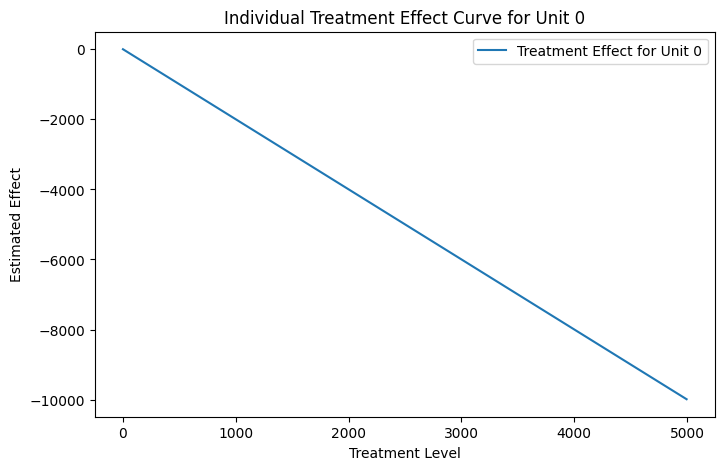

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Simulated Data
np.random.seed(42)
n = 1000
X = np.random.normal(size=(n, 5))  # Covariates
T = np.random.uniform(0, 5000, size=n)  # Continuous Treatment
Y = 2 * T + np.sin(T) + X[:, 0] + np.random.normal(size=n)  # Add nonlinearity
# Split data
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor

cf = CausalForestDML(
    model_t=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    discrete_treatment=False,
    cv=5, random_state=42
)


# Fit model
cf.fit(Y_train, T_train, X=X_train)

# Generate a range of treatment values
T_grid = np.linspace(T.min(), T.max(), 200)  # Different treatment levels
cate_values = np.array([cf.effect(X_test, T0=t) for t in T_grid])  # ✅ Correct

# Select a single unit (e.g., first unit in X_test)
cate_values_unit = cate_values[:, unit_index]  # Extract treatment effects for this unit

# Compute treatment effects for different treatment levels
cate_values_unit = np.array([cf.effect(X_unit, T0=t) for t in T_grid]).flatten()

# Plot treatment effect curve for the single unit
plt.figure(figsize=(8, 5))
plt.plot(T_grid, cate_values_unit, label=f"Treatment Effect for Unit {unit_index}")
plt.xlabel("Treatment Level")
plt.ylabel("Estimated Effect")
plt.title(f"Individual Treatment Effect Curve for Unit {unit_index}")
plt.legend()
plt.show()



[-0.40992668 -0.40990694 -0.40996625 -0.40987243 -0.41006345 -0.40940697
 -0.41054086 -0.40995274 -0.41026006 -0.41014482 -0.40995451 -0.41024604
 -0.410137   -0.41009734 -0.41018423 -0.41001946 -0.40995376 -0.41035939
 -0.41045628 -0.41001294 -0.41029185 -0.41011568 -0.41007113 -0.41042242
 -0.41017995 -0.41014756 -0.4099951  -0.40969725 -0.41018259 -0.41025088
 -0.41002824 -0.41028059 -0.40984877 -0.41047473 -0.40983289 -0.41010163
 -0.41025044 -0.40999876 -0.41024111 -0.41006675 -0.41010421 -0.41017133
 -0.41023723 -0.41008973 -0.40994095 -0.40966486 -0.4097691  -0.41019695
 -0.41002626 -0.40949663 -0.4098503  -0.41010299 -0.41015013 -0.40988378
 -0.41043304 -0.41027427 -0.40993414 -0.41015012 -0.40951705 -0.40989452
 -0.40960335 -0.40966649 -0.41008338 -0.41052433 -0.41021147 -0.41003016
 -0.41016241 -0.41018932 -0.40976729 -0.4100424  -0.4102736  -0.41045596
 -0.41045968 -0.4097363  -0.41003863 -0.41017335 -0.41019948 -0.41005825
 -0.41032271 -0.4100826  -0.41034135 -0.40989653 -0